In [1]:
import torch as torch
import pandas as pd
import numpy as np
import math
from sklearn import preprocessing
from neuralnetwork import *
from reading import *
from ADDA_Perso.ADDA import *
from ADDA_Perso.Training import *
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import umap
import os

torch.cuda.set_device(1)
device = ("cuda:1" if torch.cuda.is_available() else"cpu")
print(f"Using {device} from {torch.cuda.get_device_name()}")

2023-07-20 14:53:14.569385: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-20 14:53:16.783457: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-07-20 14:53:16.783677: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-07-20 14:53:16.783688: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like t

Using cuda:1 from NVIDIA GeForce RTX 2080 Ti


/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help` for usage information.


/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help` for usage information.




In [2]:
dataCell = domain_selection(2)
print("_________________________")
dataPatient = domain_selection(3)
print("_________________________")
cellDataloaders, input_dim, datasetCell = arrange_data_into_dataloaders(dataCell, base_bs = 32, device = device)
cellDataloadersExtractor, input_dim = use_dataset(datasetCell, base_bs = 32)
print("_________________________")
patientDataloaders, input_dim, datasetPatient = arrange_data_into_dataloaders(dataPatient, base_bs = 32, device = device)
output_dim = 1
loss_function = torch.nn.BCELoss()
classifier_loss_function = torch.nn.BCELoss()
d_loss_function = torch.nn.BCELoss()

Selection Cell domain source
All done
Name of the variable containing all cell data : cell_data
6643
_________________________
Selection Patient domain source
All done
Name of the variable containing all the data : Patient_data
21244
_________________________
6643 elements in the dataset
4649 elements in trainset
997 elements in valset
997 elements in testset
_________________________


In [3]:
source_net = Extractor(input_dim).to(device)
classifier = Classifier().to(device)
target_net = Extractor(input_dim).to(device)
discri = Wass_Discriminator(128).to(device)

target_optimizer = torch.optim.Adam(target_net.parameters(), lr=1e-4)
d_optimizer = torch.optim.Adam(discri.parameters(), lr=1e-4)
exp_param_origin="Patient_to_Cell_250_batch32_lrDiscri1e-4_lrTarget1e-4_noBatchNormDiscri_variation_Wasserstein_2discrepancy_Xavier_reduceArchi_GradPen5_RMSPROP"
exp_param = exp_param_origin
name="logger/logger_adda_"+exp_param
logger = LogResWass(name)

In [4]:
%%time
for k in range(1):
    #cellDataloaders, input_dim = use_dataset(datasetCell, base_bs = 32)
    #cellDataloadersExtractor, input_dim = use_dataset(datasetCell, base_bs = 32)
    #patientDataloaders, input_dim = use_dataset(datasetPatient, base_bs = 32)
    if k==0:
        exp_param = exp_param+"_net_"+str(k)
    else:
        exp_param = exp_param.replace("_net_"+str(k-1),"_net_"+str(k))
    
    source_net = Extractor(input_dim).to(device)
    classifier = Classifier().to(device)
    target_net = Extractor(input_dim).to(device)
    discri = Wass_Discriminator(128).to(device)

    target_optimizer = torch.optim.RMSprop(target_net.parameters(), lr=1e-4)
    d_optimizer = torch.optim.RMSprop(discri.parameters(), lr=1e-4)

    train_source(
        50,
        source_net, 
        classifier, patientDataloaders, classifier_loss_function, device,log=False)

    target_net.load_state_dict(source_net.state_dict())
    data_historique, domain_historique, cancer_historique = train_target(
        250, 
        source_net, 
        classifier,
        target_net, 
        discri, 
        target_optimizer, 
        d_optimizer, 
        loss_function, 
        d_loss_function, 
        patientDataloaders, 
        cellDataloaders,
        cellDataloadersExtractor,
        exp_param,
        10,
        device,
        1000,
        1,
        logger,
        True,
        True,
        log=False
    )

100%|██████████| 50/50 [04:36<00:00,  5.53s/it]


0.6392581720218288
 PCA Domain Ground Truth
 PCA Cancer/Sain Ground Truth
Epoch number : 0
 UMAP Domain Ground Truth
 UMAP Cancer/Sain Ground Truth
0.6310011140205768
 PCA Domain Ground Truth
 PCA Cancer/Sain Ground Truth
Epoch number : 0
 UMAP Domain Ground Truth
 UMAP Cancer/Sain Ground Truth
0.6346327884931154
 PCA Domain Ground Truth
 PCA Cancer/Sain Ground Truth
Epoch number : 0
 UMAP Domain Ground Truth
 UMAP Cancer/Sain Ground Truth


  0%|          | 1/250 [00:01<05:04,  1.22s/it]

 Epoch nimber : 0 Discri total loss: 4.785681247711182, loss_target: -7.7467780113220215, loss_source: 5.511005401611328, diff Target-Source -2.2357726097106934, gradient penalty value : 2.450740337371826 



  1%|          | 2/250 [00:02<05:03,  1.22s/it]

 Epoch nimber : 1 Discri total loss: 1.4147088527679443, loss_target: -8.912029266357422, loss_source: 7.900744915008545, diff Target-Source -1.011284351348877, gradient penalty value : 1.1090309619903564 



  1%|          | 3/250 [00:05<09:11,  2.23s/it]

 Epoch nimber : 2 Discri total loss: 2.8722219467163086, loss_target: -9.029102325439453, loss_source: 7.4373273849487305, diff Target-Source -1.5917749404907227, gradient penalty value : 1.2981206178665161 



  2%|▏         | 4/250 [00:07<07:34,  1.85s/it]

 Epoch nimber : 3 Discri total loss: 1.2510271072387695, loss_target: -8.593920707702637, loss_source: 8.227750778198242, diff Target-Source -0.36616992950439453, gradient penalty value : 1.3428926467895508 



  2%|▏         | 5/250 [00:08<06:39,  1.63s/it]

 Epoch nimber : 4 Discri total loss: 3.4149675369262695, loss_target: -8.803104400634766, loss_source: 8.410346984863281, diff Target-Source -0.3927574157714844, gradient penalty value : 1.9686239957809448 



  2%|▏         | 6/250 [00:09<06:06,  1.50s/it]

 Epoch nimber : 5 Discri total loss: 2.131368398666382, loss_target: -8.810525894165039, loss_source: 7.959178447723389, diff Target-Source -0.8513474464416504, gradient penalty value : 1.1124403476715088 



  3%|▎         | 7/250 [00:10<05:46,  1.42s/it]

 Epoch nimber : 6 Discri total loss: 2.9900197982788086, loss_target: -8.921661376953125, loss_source: 7.59896993637085, diff Target-Source -1.3226914405822754, gradient penalty value : 0.8506350517272949 



  3%|▎         | 8/250 [00:12<05:31,  1.37s/it]

 Epoch nimber : 7 Discri total loss: 3.88305926322937, loss_target: -8.532546997070312, loss_source: 7.077580451965332, diff Target-Source -1.4549665451049805, gradient penalty value : 1.4316318035125732 



  4%|▎         | 9/250 [00:13<05:21,  1.33s/it]

 Epoch nimber : 8 Discri total loss: 2.287780284881592, loss_target: -8.633602142333984, loss_source: 7.1468048095703125, diff Target-Source -1.4867973327636719, gradient penalty value : 1.1989549398422241 



  4%|▍         | 10/250 [00:14<05:13,  1.31s/it]

 Epoch nimber : 9 Discri total loss: 2.1919658184051514, loss_target: -8.827882766723633, loss_source: 7.313889503479004, diff Target-Source -1.513993263244629, gradient penalty value : 0.8847129344940186 



  4%|▍         | 11/250 [00:17<07:36,  1.91s/it]

 Epoch nimber : 10 Discri total loss: 2.075045347213745, loss_target: -8.8682222366333, loss_source: 7.294807434082031, diff Target-Source -1.5734148025512695, gradient penalty value : 1.006803274154663 



  5%|▍         | 12/250 [00:19<06:46,  1.71s/it]

 Epoch nimber : 11 Discri total loss: 3.461479425430298, loss_target: -8.753212928771973, loss_source: 7.4385786056518555, diff Target-Source -1.3146343231201172, gradient penalty value : 1.4355509281158447 



  5%|▌         | 13/250 [00:20<06:11,  1.57s/it]

 Epoch nimber : 12 Discri total loss: 2.5175833702087402, loss_target: -8.348926544189453, loss_source: 6.435657024383545, diff Target-Source -1.9132695198059082, gradient penalty value : 0.6344422698020935 



  6%|▌         | 14/250 [00:21<05:46,  1.47s/it]

 Epoch nimber : 13 Discri total loss: 2.000701427459717, loss_target: -8.55919075012207, loss_source: 7.1072540283203125, diff Target-Source -1.4519367218017578, gradient penalty value : 0.7158302068710327 



  6%|▌         | 15/250 [00:22<05:29,  1.40s/it]

 Epoch nimber : 14 Discri total loss: 2.7797064781188965, loss_target: -8.381747245788574, loss_source: 6.479160308837891, diff Target-Source -1.9025869369506836, gradient penalty value : 1.0075699090957642 



  6%|▋         | 16/250 [00:24<05:16,  1.35s/it]

 Epoch nimber : 15 Discri total loss: 1.5416841506958008, loss_target: -8.632905960083008, loss_source: 7.017540454864502, diff Target-Source -1.6153655052185059, gradient penalty value : 0.5023398995399475 



  7%|▋         | 17/250 [00:25<05:07,  1.32s/it]

 Epoch nimber : 16 Discri total loss: 3.1353917121887207, loss_target: -8.664588928222656, loss_source: 6.810100555419922, diff Target-Source -1.8544883728027344, gradient penalty value : 0.7365097999572754 



  7%|▋         | 18/250 [00:26<05:00,  1.30s/it]

 Epoch nimber : 17 Discri total loss: 2.019815444946289, loss_target: -8.76101303100586, loss_source: 7.123653411865234, diff Target-Source -1.637359619140625, gradient penalty value : 0.8973389863967896 



  8%|▊         | 19/250 [00:27<04:56,  1.28s/it]

 Epoch nimber : 18 Discri total loss: 2.59806489944458, loss_target: -8.670783996582031, loss_source: 7.0466413497924805, diff Target-Source -1.6241426467895508, gradient penalty value : 1.3095117807388306 



  8%|▊         | 20/250 [00:30<06:52,  1.79s/it]

 Epoch nimber : 19 Discri total loss: 2.3367836475372314, loss_target: -8.200048446655273, loss_source: 6.590385437011719, diff Target-Source -1.6096630096435547, gradient penalty value : 0.9191267490386963 



  8%|▊         | 21/250 [00:32<06:12,  1.63s/it]

 Epoch nimber : 20 Discri total loss: 3.433466911315918, loss_target: -8.403753280639648, loss_source: 6.147455215454102, diff Target-Source -2.256298065185547, gradient penalty value : 1.025665283203125 



  9%|▉         | 22/250 [00:33<05:46,  1.52s/it]

 Epoch nimber : 21 Discri total loss: 3.5335452556610107, loss_target: -8.503074645996094, loss_source: 6.371027946472168, diff Target-Source -2.132046699523926, gradient penalty value : 1.3505170345306396 



  9%|▉         | 23/250 [00:34<05:26,  1.44s/it]

 Epoch nimber : 22 Discri total loss: 2.2695260047912598, loss_target: -8.73054313659668, loss_source: 7.0184006690979, diff Target-Source -1.7121424674987793, gradient penalty value : 0.6907415390014648 



 10%|▉         | 24/250 [00:35<05:12,  1.38s/it]

 Epoch nimber : 23 Discri total loss: 3.341632127761841, loss_target: -8.786779403686523, loss_source: 6.574528694152832, diff Target-Source -2.2122507095336914, gradient penalty value : 1.2340948581695557 



 10%|█         | 25/250 [00:37<05:02,  1.34s/it]

 Epoch nimber : 24 Discri total loss: 3.079421043395996, loss_target: -7.698479175567627, loss_source: 6.349584579467773, diff Target-Source -1.3488945960998535, gradient penalty value : 1.0200062990188599 



 10%|█         | 26/250 [00:38<04:54,  1.31s/it]

 Epoch nimber : 25 Discri total loss: 2.287236213684082, loss_target: -8.64927864074707, loss_source: 6.8631110191345215, diff Target-Source -1.7861676216125488, gradient penalty value : 0.7116743326187134 



 11%|█         | 27/250 [00:39<04:48,  1.29s/it]

 Epoch nimber : 26 Discri total loss: 2.7530601024627686, loss_target: -8.685401916503906, loss_source: 6.59011173248291, diff Target-Source -2.095290184020996, gradient penalty value : 0.6118753552436829 



 11%|█         | 28/250 [00:42<06:47,  1.84s/it]

 Epoch nimber : 27 Discri total loss: 3.097902774810791, loss_target: -8.817296981811523, loss_source: 6.6032395362854, diff Target-Source -2.214057445526123, gradient penalty value : 1.2260255813598633 



 12%|█▏        | 29/250 [00:43<06:06,  1.66s/it]

 Epoch nimber : 28 Discri total loss: 3.770202875137329, loss_target: -8.263465881347656, loss_source: 5.906548500061035, diff Target-Source -2.356917381286621, gradient penalty value : 1.0560276508331299 



 12%|█▏        | 30/250 [00:45<05:38,  1.54s/it]

 Epoch nimber : 29 Discri total loss: 3.2095799446105957, loss_target: -8.394380569458008, loss_source: 6.489957809448242, diff Target-Source -1.9044227600097656, gradient penalty value : 1.0746206045150757 



 12%|█▏        | 31/250 [00:46<05:15,  1.44s/it]

 Epoch nimber : 30 Discri total loss: 2.510984182357788, loss_target: -8.584802627563477, loss_source: 6.445345878601074, diff Target-Source -2.1394567489624023, gradient penalty value : 0.5869204998016357 



 13%|█▎        | 32/250 [00:47<05:02,  1.39s/it]

 Epoch nimber : 31 Discri total loss: 3.1591219902038574, loss_target: -8.454099655151367, loss_source: 5.745394706726074, diff Target-Source -2.708704948425293, gradient penalty value : 0.7148193717002869 



 13%|█▎        | 33/250 [00:48<04:51,  1.34s/it]

 Epoch nimber : 32 Discri total loss: 4.080132961273193, loss_target: -8.34630012512207, loss_source: 5.581991672515869, diff Target-Source -2.764308452606201, gradient penalty value : 0.8917036056518555 



 14%|█▎        | 34/250 [00:50<04:43,  1.31s/it]

 Epoch nimber : 33 Discri total loss: 3.753401756286621, loss_target: -8.430479049682617, loss_source: 5.674136161804199, diff Target-Source -2.756342887878418, gradient penalty value : 1.3733463287353516 

 Epoch nimber : 34 Discri total loss: 3.4252796173095703, loss_target: -8.515684127807617, loss_source: 5.7386980056762695, diff Target-Source -2.7769861221313477, gradient penalty value : 1.1641525030136108 



 14%|█▍        | 36/250 [00:54<06:01,  1.69s/it]

 Epoch nimber : 35 Discri total loss: 3.65232515335083, loss_target: -8.010303497314453, loss_source: 5.832339286804199, diff Target-Source -2.177964210510254, gradient penalty value : 1.0353161096572876 



 15%|█▍        | 37/250 [00:55<05:31,  1.56s/it]

 Epoch nimber : 36 Discri total loss: 3.6247036457061768, loss_target: -8.274408340454102, loss_source: 5.44062614440918, diff Target-Source -2.833782196044922, gradient penalty value : 1.0753700733184814 



 15%|█▌        | 38/250 [00:57<05:10,  1.47s/it]

 Epoch nimber : 37 Discri total loss: 4.078125953674316, loss_target: -8.349684715270996, loss_source: 5.220830917358398, diff Target-Source -3.1288537979125977, gradient penalty value : 1.2184686660766602 



 16%|█▌        | 39/250 [00:58<04:55,  1.40s/it]

 Epoch nimber : 38 Discri total loss: 4.056992530822754, loss_target: -8.445127487182617, loss_source: 5.846720218658447, diff Target-Source -2.59840726852417, gradient penalty value : 1.0588363409042358 



 16%|█▌        | 40/250 [00:59<04:44,  1.35s/it]

 Epoch nimber : 39 Discri total loss: 2.810248851776123, loss_target: -8.44002914428711, loss_source: 6.2560858726501465, diff Target-Source -2.183943271636963, gradient penalty value : 1.0935635566711426 



 16%|█▋        | 41/250 [01:00<04:36,  1.32s/it]

 Epoch nimber : 40 Discri total loss: 3.1616597175598145, loss_target: -8.357303619384766, loss_source: 5.735143184661865, diff Target-Source -2.6221604347229004, gradient penalty value : 0.8934153318405151 



 17%|█▋        | 42/250 [01:02<04:30,  1.30s/it]

 Epoch nimber : 41 Discri total loss: 3.0260109901428223, loss_target: -8.260379791259766, loss_source: 5.731073379516602, diff Target-Source -2.529306411743164, gradient penalty value : 0.8604084253311157 



 17%|█▋        | 43/250 [01:05<06:14,  1.81s/it]

 Epoch nimber : 42 Discri total loss: 2.4230117797851562, loss_target: -8.157014846801758, loss_source: 6.3851728439331055, diff Target-Source -1.7718420028686523, gradient penalty value : 0.744409441947937 



 18%|█▊        | 44/250 [01:06<05:38,  1.64s/it]

 Epoch nimber : 43 Discri total loss: 4.231624603271484, loss_target: -8.225408554077148, loss_source: 5.020529270172119, diff Target-Source -3.2048792839050293, gradient penalty value : 0.8339753746986389 



 18%|█▊        | 45/250 [01:07<05:13,  1.53s/it]

 Epoch nimber : 44 Discri total loss: 3.6132469177246094, loss_target: -8.18395709991455, loss_source: 5.418761253356934, diff Target-Source -2.765195846557617, gradient penalty value : 1.0256013870239258 



 18%|█▊        | 46/250 [01:08<04:54,  1.44s/it]

 Epoch nimber : 45 Discri total loss: 4.026036739349365, loss_target: -8.162921905517578, loss_source: 5.2179107666015625, diff Target-Source -2.9450111389160156, gradient penalty value : 1.0672869682312012 



 19%|█▉        | 47/250 [01:10<04:41,  1.39s/it]

 Epoch nimber : 46 Discri total loss: 3.866511106491089, loss_target: -8.312597274780273, loss_source: 5.283195495605469, diff Target-Source -3.0294017791748047, gradient penalty value : 0.9969985485076904 



 19%|█▉        | 48/250 [01:11<04:32,  1.35s/it]

 Epoch nimber : 47 Discri total loss: 4.360097885131836, loss_target: -7.802976608276367, loss_source: 5.036380767822266, diff Target-Source -2.7665958404541016, gradient penalty value : 1.2434321641921997 



 20%|█▉        | 49/250 [01:12<04:24,  1.32s/it]

 Epoch nimber : 48 Discri total loss: 4.38709020614624, loss_target: -8.241235733032227, loss_source: 5.085890769958496, diff Target-Source -3.1553449630737305, gradient penalty value : 1.2722879648208618 



 20%|██        | 50/250 [01:13<04:20,  1.30s/it]

 Epoch nimber : 49 Discri total loss: 4.169360637664795, loss_target: -8.235528945922852, loss_source: 5.2522053718566895, diff Target-Source -2.983323574066162, gradient penalty value : 1.2175531387329102 

 Epoch nimber : 50 Discri total loss: 5.137982368469238, loss_target: -8.226263046264648, loss_source: 4.876573085784912, diff Target-Source -3.3496899604797363, gradient penalty value : 1.6712825298309326 



 21%|██        | 52/250 [01:18<05:34,  1.69s/it]

 Epoch nimber : 51 Discri total loss: 3.5740857124328613, loss_target: -7.9705400466918945, loss_source: 5.209726333618164, diff Target-Source -2.7608137130737305, gradient penalty value : 1.029344916343689 



 21%|██        | 53/250 [01:19<05:06,  1.56s/it]

 Epoch nimber : 52 Discri total loss: 4.321454048156738, loss_target: -7.570752143859863, loss_source: 4.768014907836914, diff Target-Source -2.802737236022949, gradient penalty value : 1.1815840005874634 



 22%|██▏       | 54/250 [01:20<04:46,  1.46s/it]

 Epoch nimber : 53 Discri total loss: 4.767230987548828, loss_target: -8.130481719970703, loss_source: 4.770683765411377, diff Target-Source -3.359797954559326, gradient penalty value : 1.8023812770843506 



 22%|██▏       | 55/250 [01:22<04:33,  1.40s/it]

 Epoch nimber : 54 Discri total loss: 4.9846906661987305, loss_target: -7.509610176086426, loss_source: 4.589155197143555, diff Target-Source -2.920454978942871, gradient penalty value : 1.840604305267334 



 22%|██▏       | 56/250 [01:23<04:23,  1.36s/it]

 Epoch nimber : 55 Discri total loss: 3.6052589416503906, loss_target: -7.256916046142578, loss_source: 5.221746444702148, diff Target-Source -2.0351696014404297, gradient penalty value : 1.4491024017333984 



 23%|██▎       | 57/250 [01:24<04:15,  1.32s/it]

 Epoch nimber : 56 Discri total loss: 4.455734729766846, loss_target: -7.890324592590332, loss_source: 4.140233516693115, diff Target-Source -3.750091075897217, gradient penalty value : 1.2041586637496948 



 23%|██▎       | 58/250 [01:25<04:09,  1.30s/it]

 Epoch nimber : 57 Discri total loss: 3.6727535724639893, loss_target: -7.725541591644287, loss_source: 4.944263458251953, diff Target-Source -2.781278133392334, gradient penalty value : 1.1258995532989502 



 24%|██▎       | 59/250 [01:27<04:06,  1.29s/it]

 Epoch nimber : 58 Discri total loss: 4.340248107910156, loss_target: -7.810250282287598, loss_source: 4.878560543060303, diff Target-Source -2.931689739227295, gradient penalty value : 1.3087306022644043 



 24%|██▍       | 60/250 [01:30<05:47,  1.83s/it]

 Epoch nimber : 59 Discri total loss: 4.880222797393799, loss_target: -7.53403902053833, loss_source: 4.802804946899414, diff Target-Source -2.731234073638916, gradient penalty value : 1.700095534324646 



 24%|██▍       | 61/250 [01:31<05:12,  1.65s/it]

 Epoch nimber : 60 Discri total loss: 4.0495710372924805, loss_target: -7.578438758850098, loss_source: 4.620661735534668, diff Target-Source -2.9577770233154297, gradient penalty value : 1.2496150732040405 



 25%|██▍       | 62/250 [01:32<04:48,  1.53s/it]

 Epoch nimber : 61 Discri total loss: 4.959071636199951, loss_target: -7.699584007263184, loss_source: 4.629086017608643, diff Target-Source -3.070497989654541, gradient penalty value : 1.4415186643600464 



 25%|██▌       | 63/250 [01:33<04:31,  1.45s/it]

 Epoch nimber : 62 Discri total loss: 4.3444437980651855, loss_target: -7.949877738952637, loss_source: 5.003277778625488, diff Target-Source -2.9465999603271484, gradient penalty value : 1.4890847206115723 



 26%|██▌       | 64/250 [01:35<04:17,  1.38s/it]

 Epoch nimber : 63 Discri total loss: 4.859104156494141, loss_target: -7.991286277770996, loss_source: 4.556215286254883, diff Target-Source -3.4350709915161133, gradient penalty value : 1.699219822883606 



 26%|██▌       | 65/250 [01:36<04:09,  1.35s/it]

 Epoch nimber : 64 Discri total loss: 4.116484642028809, loss_target: -7.6013946533203125, loss_source: 4.948519706726074, diff Target-Source -2.6528749465942383, gradient penalty value : 1.530868411064148 



 26%|██▋       | 66/250 [01:37<04:03,  1.32s/it]

 Epoch nimber : 65 Discri total loss: 4.720972061157227, loss_target: -7.446664333343506, loss_source: 4.687743663787842, diff Target-Source -2.758920669555664, gradient penalty value : 1.6318070888519287 



 27%|██▋       | 67/250 [01:38<03:58,  1.30s/it]

 Epoch nimber : 66 Discri total loss: 5.126165390014648, loss_target: -7.983128547668457, loss_source: 4.246780872344971, diff Target-Source -3.7363476753234863, gradient penalty value : 1.5616095066070557 



 27%|██▋       | 68/250 [01:42<05:31,  1.82s/it]

 Epoch nimber : 67 Discri total loss: 4.669528007507324, loss_target: -7.185522556304932, loss_source: 4.701833248138428, diff Target-Source -2.483689308166504, gradient penalty value : 1.6292359828948975 



 28%|██▊       | 69/250 [01:43<05:00,  1.66s/it]

 Epoch nimber : 68 Discri total loss: 4.84287166595459, loss_target: -8.199979782104492, loss_source: 4.849979877471924, diff Target-Source -3.3499999046325684, gradient penalty value : 1.4210516214370728 



 28%|██▊       | 70/250 [01:44<04:37,  1.54s/it]

 Epoch nimber : 69 Discri total loss: 4.320323467254639, loss_target: -7.8594465255737305, loss_source: 4.5637006759643555, diff Target-Source -3.295745849609375, gradient penalty value : 1.1476777791976929 



 28%|██▊       | 71/250 [01:45<04:20,  1.45s/it]

 Epoch nimber : 70 Discri total loss: 4.858903884887695, loss_target: -7.616309642791748, loss_source: 4.656777858734131, diff Target-Source -2.959531784057617, gradient penalty value : 1.9601410627365112 



 29%|██▉       | 72/250 [01:47<04:09,  1.40s/it]

 Epoch nimber : 71 Discri total loss: 5.848129749298096, loss_target: -8.007889747619629, loss_source: 4.460033893585205, diff Target-Source -3.547855854034424, gradient penalty value : 2.7206153869628906 



 29%|██▉       | 73/250 [01:48<04:01,  1.36s/it]

 Epoch nimber : 72 Discri total loss: 4.781240463256836, loss_target: -7.8119306564331055, loss_source: 4.438080787658691, diff Target-Source -3.373849868774414, gradient penalty value : 1.6443238258361816 



 30%|██▉       | 74/250 [01:49<03:55,  1.34s/it]

 Epoch nimber : 73 Discri total loss: 4.825421333312988, loss_target: -7.767195701599121, loss_source: 4.908367156982422, diff Target-Source -2.858828544616699, gradient penalty value : 1.8321444988250732 



 30%|███       | 75/250 [01:50<03:48,  1.31s/it]

 Epoch nimber : 74 Discri total loss: 5.5276875495910645, loss_target: -8.13560676574707, loss_source: 4.349043846130371, diff Target-Source -3.786562919616699, gradient penalty value : 1.8637728691101074 



 30%|███       | 76/250 [01:54<05:29,  1.90s/it]

 Epoch nimber : 75 Discri total loss: 4.840475559234619, loss_target: -7.763743877410889, loss_source: 4.706674575805664, diff Target-Source -3.0570693016052246, gradient penalty value : 1.7840992212295532 



 31%|███       | 77/250 [01:55<04:54,  1.70s/it]

 Epoch nimber : 76 Discri total loss: 4.908628940582275, loss_target: -7.644428253173828, loss_source: 4.42492151260376, diff Target-Source -3.2195067405700684, gradient penalty value : 1.6085416078567505 



 31%|███       | 78/250 [01:56<04:28,  1.56s/it]

 Epoch nimber : 77 Discri total loss: 5.531888961791992, loss_target: -7.406770706176758, loss_source: 4.447770118713379, diff Target-Source -2.959000587463379, gradient penalty value : 2.1649491786956787 



 32%|███▏      | 79/250 [01:57<04:12,  1.48s/it]

 Epoch nimber : 78 Discri total loss: 4.579667091369629, loss_target: -7.10244083404541, loss_source: 4.603152751922607, diff Target-Source -2.4992880821228027, gradient penalty value : 1.4204201698303223 



 32%|███▏      | 80/250 [01:59<04:00,  1.41s/it]

 Epoch nimber : 79 Discri total loss: 5.603673934936523, loss_target: -7.8061065673828125, loss_source: 4.451564788818359, diff Target-Source -3.354541778564453, gradient penalty value : 2.563908100128174 



 32%|███▏      | 81/250 [02:00<03:51,  1.37s/it]

 Epoch nimber : 80 Discri total loss: 5.759920120239258, loss_target: -8.210029602050781, loss_source: 4.359433174133301, diff Target-Source -3.8505964279174805, gradient penalty value : 1.9765236377716064 



 33%|███▎      | 82/250 [02:01<03:43,  1.33s/it]

 Epoch nimber : 81 Discri total loss: 4.660401344299316, loss_target: -7.311703681945801, loss_source: 4.702635765075684, diff Target-Source -2.609067916870117, gradient penalty value : 1.328328251838684 



 33%|███▎      | 83/250 [02:02<03:38,  1.31s/it]

 Epoch nimber : 82 Discri total loss: 5.216679573059082, loss_target: -7.923639297485352, loss_source: 4.329946041107178, diff Target-Source -3.593693256378174, gradient penalty value : 1.9376802444458008 



 34%|███▎      | 84/250 [02:05<05:00,  1.81s/it]

 Epoch nimber : 83 Discri total loss: 5.031801700592041, loss_target: -7.75826358795166, loss_source: 4.095487117767334, diff Target-Source -3.662776470184326, gradient penalty value : 1.8482694625854492 



 34%|███▍      | 85/250 [02:07<04:32,  1.65s/it]

 Epoch nimber : 84 Discri total loss: 5.283000469207764, loss_target: -7.812925338745117, loss_source: 4.282803535461426, diff Target-Source -3.5301218032836914, gradient penalty value : 2.03726863861084 



 34%|███▍      | 86/250 [02:08<04:11,  1.53s/it]

 Epoch nimber : 85 Discri total loss: 5.77622652053833, loss_target: -7.566171646118164, loss_source: 4.160242557525635, diff Target-Source -3.4059290885925293, gradient penalty value : 2.5565638542175293 



 35%|███▍      | 87/250 [02:09<03:56,  1.45s/it]

 Epoch nimber : 86 Discri total loss: 4.864872932434082, loss_target: -7.982739448547363, loss_source: 4.76640510559082, diff Target-Source -3.216334342956543, gradient penalty value : 1.9922345876693726 



 35%|███▌      | 88/250 [02:10<03:45,  1.39s/it]

 Epoch nimber : 87 Discri total loss: 5.375733375549316, loss_target: -7.940761566162109, loss_source: 4.455704689025879, diff Target-Source -3.4850568771362305, gradient penalty value : 2.0165774822235107 



 36%|███▌      | 89/250 [02:12<03:36,  1.35s/it]

 Epoch nimber : 88 Discri total loss: 5.280918121337891, loss_target: -8.01081657409668, loss_source: 4.243137836456299, diff Target-Source -3.767678737640381, gradient penalty value : 1.7199230194091797 



 36%|███▌      | 90/250 [02:13<03:30,  1.32s/it]

 Epoch nimber : 89 Discri total loss: 5.340012550354004, loss_target: -7.932718276977539, loss_source: 4.460027694702148, diff Target-Source -3.4726905822753906, gradient penalty value : 2.2278804779052734 

 Epoch nimber : 90 Discri total loss: 4.847657680511475, loss_target: -7.800346374511719, loss_source: 4.496766090393066, diff Target-Source -3.3035802841186523, gradient penalty value : 1.8659271001815796 



 37%|███▋      | 92/250 [02:17<04:25,  1.68s/it]

 Epoch nimber : 91 Discri total loss: 5.300860404968262, loss_target: -7.604046821594238, loss_source: 4.5909953117370605, diff Target-Source -3.0130515098571777, gradient penalty value : 2.105156421661377 



 37%|███▋      | 93/250 [02:19<04:04,  1.55s/it]

 Epoch nimber : 92 Discri total loss: 5.199933052062988, loss_target: -7.832435607910156, loss_source: 4.02594518661499, diff Target-Source -3.806490421295166, gradient penalty value : 1.9285643100738525 



 38%|███▊      | 94/250 [02:20<03:48,  1.46s/it]

 Epoch nimber : 93 Discri total loss: 5.7985687255859375, loss_target: -7.796731948852539, loss_source: 4.15329122543335, diff Target-Source -3.6434407234191895, gradient penalty value : 2.262695074081421 



 38%|███▊      | 95/250 [02:21<03:36,  1.40s/it]

 Epoch nimber : 94 Discri total loss: 5.106968879699707, loss_target: -7.5952277183532715, loss_source: 4.398812770843506, diff Target-Source -3.1964149475097656, gradient penalty value : 1.983703374862671 



 38%|███▊      | 96/250 [02:22<03:28,  1.35s/it]

 Epoch nimber : 95 Discri total loss: 5.647071361541748, loss_target: -7.7481794357299805, loss_source: 4.068366050720215, diff Target-Source -3.6798133850097656, gradient penalty value : 2.394599437713623 



 39%|███▉      | 97/250 [02:24<03:22,  1.32s/it]

 Epoch nimber : 96 Discri total loss: 6.267899990081787, loss_target: -6.931693077087402, loss_source: 3.9430036544799805, diff Target-Source -2.988689422607422, gradient penalty value : 2.4032750129699707 



 39%|███▉      | 98/250 [02:25<03:18,  1.30s/it]

 Epoch nimber : 97 Discri total loss: 5.409174919128418, loss_target: -7.033082962036133, loss_source: 3.9128308296203613, diff Target-Source -3.1202521324157715, gradient penalty value : 2.6718056201934814 



 40%|███▉      | 99/250 [02:26<03:14,  1.29s/it]

 Epoch nimber : 98 Discri total loss: 6.115077495574951, loss_target: -7.311762809753418, loss_source: 3.727950096130371, diff Target-Source -3.583812713623047, gradient penalty value : 2.548290252685547 



 40%|████      | 100/250 [02:29<04:35,  1.83s/it]

 Epoch nimber : 99 Discri total loss: 5.616458415985107, loss_target: -7.564713478088379, loss_source: 3.701378345489502, diff Target-Source -3.863335132598877, gradient penalty value : 2.2775468826293945 

 Epoch nimber : 100 Discri total loss: 5.561075210571289, loss_target: -7.500779628753662, loss_source: 3.814628839492798, diff Target-Source -3.6861507892608643, gradient penalty value : 2.448543071746826 

0.6485794956271842
 PCA Domain Ground Truth
 PCA Cancer/Sain Ground Truth
Epoch number : 100
 UMAP Domain Ground Truth
 UMAP Cancer/Sain Ground Truth
0.6413258779716043
 PCA Domain Ground Truth
 PCA Cancer/Sain Ground Truth
Epoch number : 100
 UMAP Domain Ground Truth
 UMAP Cancer/Sain Ground Truth
0.6348097934038152
 PCA Domain Ground Truth
 PCA Cancer/Sain Ground Truth
Epoch number : 100
 UMAP Domain Ground Truth
 UMAP Cancer/Sain Ground Truth


 41%|████      | 102/250 [03:07<22:11,  9.00s/it]

 Epoch nimber : 101 Discri total loss: 6.438088417053223, loss_target: -7.330070495605469, loss_source: 3.7258431911468506, diff Target-Source -3.604227304458618, gradient penalty value : 3.1050186157226562 



 41%|████      | 103/250 [03:09<16:19,  6.67s/it]

 Epoch nimber : 102 Discri total loss: 6.2176666259765625, loss_target: -7.04587984085083, loss_source: 3.6461172103881836, diff Target-Source -3.3997626304626465, gradient penalty value : 2.702165126800537 



 42%|████▏     | 104/250 [03:10<12:13,  5.02s/it]

 Epoch nimber : 103 Discri total loss: 6.119309902191162, loss_target: -7.122471809387207, loss_source: 3.5831375122070312, diff Target-Source -3.539334297180176, gradient penalty value : 2.4739556312561035 



 42%|████▏     | 105/250 [03:13<11:10,  4.62s/it]

 Epoch nimber : 104 Discri total loss: 6.51641845703125, loss_target: -6.980369567871094, loss_source: 3.5224263668060303, diff Target-Source -3.4579432010650635, gradient penalty value : 2.740894317626953 



 42%|████▏     | 106/250 [03:15<08:39,  3.61s/it]

 Epoch nimber : 105 Discri total loss: 5.394436359405518, loss_target: -6.788613319396973, loss_source: 3.9133496284484863, diff Target-Source -2.8752636909484863, gradient penalty value : 2.49735164642334 



 43%|████▎     | 107/250 [03:16<06:54,  2.90s/it]

 Epoch nimber : 106 Discri total loss: 6.332640647888184, loss_target: -6.705625534057617, loss_source: 3.3697378635406494, diff Target-Source -3.3358876705169678, gradient penalty value : 2.9902758598327637 



 43%|████▎     | 108/250 [03:17<05:42,  2.41s/it]

 Epoch nimber : 107 Discri total loss: 6.527112007141113, loss_target: -5.911869049072266, loss_source: 3.4241275787353516, diff Target-Source -2.487741470336914, gradient penalty value : 3.264777898788452 



 44%|████▎     | 109/250 [03:18<04:49,  2.06s/it]

 Epoch nimber : 108 Discri total loss: 6.141085147857666, loss_target: -6.537446022033691, loss_source: 3.6429524421691895, diff Target-Source -2.894493579864502, gradient penalty value : 3.0649948120117188 



 44%|████▍     | 110/250 [03:20<04:13,  1.81s/it]

 Epoch nimber : 109 Discri total loss: 5.837964057922363, loss_target: -6.631433010101318, loss_source: 3.821296215057373, diff Target-Source -2.8101367950439453, gradient penalty value : 3.029609203338623 



 44%|████▍     | 111/250 [03:21<03:47,  1.64s/it]

 Epoch nimber : 110 Discri total loss: 7.541599273681641, loss_target: -6.58906364440918, loss_source: 3.403662919998169, diff Target-Source -3.1854007244110107, gradient penalty value : 4.509641647338867 



 45%|████▍     | 112/250 [03:22<03:30,  1.53s/it]

 Epoch nimber : 111 Discri total loss: 6.340807914733887, loss_target: -6.410350322723389, loss_source: 3.337559461593628, diff Target-Source -3.0727908611297607, gradient penalty value : 3.2907705307006836 



 45%|████▌     | 113/250 [03:23<03:17,  1.44s/it]

 Epoch nimber : 112 Discri total loss: 6.279561996459961, loss_target: -6.635507583618164, loss_source: 3.5146641731262207, diff Target-Source -3.1208434104919434, gradient penalty value : 3.205686092376709 

 Epoch nimber : 113 Discri total loss: 7.008628845214844, loss_target: -6.591440677642822, loss_source: 3.507082462310791, diff Target-Source -3.0843582153320312, gradient penalty value : 3.759077787399292 



 46%|████▌     | 115/250 [03:28<03:54,  1.74s/it]

 Epoch nimber : 114 Discri total loss: 6.2105560302734375, loss_target: -6.713586807250977, loss_source: 3.610013246536255, diff Target-Source -3.1035735607147217, gradient penalty value : 3.2685794830322266 



 46%|████▋     | 116/250 [03:29<03:32,  1.58s/it]

 Epoch nimber : 115 Discri total loss: 6.510734558105469, loss_target: -6.559595108032227, loss_source: 3.4837961196899414, diff Target-Source -3.075798988342285, gradient penalty value : 3.1589162349700928 



 47%|████▋     | 117/250 [03:30<03:17,  1.48s/it]

 Epoch nimber : 116 Discri total loss: 5.852303981781006, loss_target: -6.535523414611816, loss_source: 3.6745352745056152, diff Target-Source -2.860988140106201, gradient penalty value : 3.032581329345703 



 47%|████▋     | 118/250 [03:31<03:06,  1.41s/it]

 Epoch nimber : 117 Discri total loss: 6.703571319580078, loss_target: -6.36486291885376, loss_source: 3.4300413131713867, diff Target-Source -2.934821605682373, gradient penalty value : 3.8159468173980713 



 48%|████▊     | 119/250 [03:33<02:59,  1.37s/it]

 Epoch nimber : 118 Discri total loss: 5.74463415145874, loss_target: -6.272729873657227, loss_source: 3.3697242736816406, diff Target-Source -2.903005599975586, gradient penalty value : 2.8063173294067383 



 48%|████▊     | 120/250 [03:34<02:53,  1.33s/it]

 Epoch nimber : 119 Discri total loss: 6.661107063293457, loss_target: -6.246512413024902, loss_source: 3.2395386695861816, diff Target-Source -3.0069737434387207, gradient penalty value : 3.6888179779052734 



 48%|████▊     | 121/250 [03:35<02:48,  1.30s/it]

 Epoch nimber : 120 Discri total loss: 6.748547554016113, loss_target: -6.123374938964844, loss_source: 3.0575382709503174, diff Target-Source -3.0658366680145264, gradient penalty value : 3.7044997215270996 



 49%|████▉     | 122/250 [03:37<02:45,  1.29s/it]

 Epoch nimber : 121 Discri total loss: 7.174283027648926, loss_target: -6.2447099685668945, loss_source: 3.024144411087036, diff Target-Source -3.2205655574798584, gradient penalty value : 4.147158622741699 



 49%|████▉     | 123/250 [03:40<04:01,  1.90s/it]

 Epoch nimber : 122 Discri total loss: 7.716897964477539, loss_target: -6.327692985534668, loss_source: 3.162221670150757, diff Target-Source -3.165471315383911, gradient penalty value : 4.38485050201416 



 50%|████▉     | 124/250 [03:41<03:35,  1.71s/it]

 Epoch nimber : 123 Discri total loss: 8.081344604492188, loss_target: -5.79965877532959, loss_source: 2.589282989501953, diff Target-Source -3.2103757858276367, gradient penalty value : 4.646951675415039 



 50%|█████     | 125/250 [03:42<03:17,  1.58s/it]

 Epoch nimber : 124 Discri total loss: 7.6377105712890625, loss_target: -5.96375846862793, loss_source: 2.9011874198913574, diff Target-Source -3.0625710487365723, gradient penalty value : 4.715756893157959 



 50%|█████     | 126/250 [03:44<03:03,  1.48s/it]

 Epoch nimber : 125 Discri total loss: 5.967892169952393, loss_target: -6.126078128814697, loss_source: 2.8816609382629395, diff Target-Source -3.244417190551758, gradient penalty value : 2.779078483581543 



 51%|█████     | 127/250 [03:45<02:53,  1.41s/it]

 Epoch nimber : 126 Discri total loss: 6.599513530731201, loss_target: -6.187666416168213, loss_source: 3.075234889984131, diff Target-Source -3.112431526184082, gradient penalty value : 3.4710006713867188 



 51%|█████     | 128/250 [03:46<02:46,  1.36s/it]

 Epoch nimber : 127 Discri total loss: 6.746962070465088, loss_target: -6.5951948165893555, loss_source: 3.000494956970215, diff Target-Source -3.5946998596191406, gradient penalty value : 3.235283374786377 



 52%|█████▏    | 129/250 [03:47<02:41,  1.33s/it]

 Epoch nimber : 128 Discri total loss: 6.571866035461426, loss_target: -6.422408103942871, loss_source: 3.1849136352539062, diff Target-Source -3.237494468688965, gradient penalty value : 3.4735708236694336 



 52%|█████▏    | 130/250 [03:49<02:36,  1.30s/it]

 Epoch nimber : 129 Discri total loss: 5.807068824768066, loss_target: -6.542820930480957, loss_source: 3.4243922233581543, diff Target-Source -3.1184287071228027, gradient penalty value : 2.8217828273773193 



 52%|█████▏    | 131/250 [03:52<03:50,  1.94s/it]

 Epoch nimber : 130 Discri total loss: 6.429563045501709, loss_target: -6.391395568847656, loss_source: 3.050483226776123, diff Target-Source -3.340912342071533, gradient penalty value : 3.3062362670898438 



 53%|█████▎    | 132/250 [03:53<03:24,  1.73s/it]

 Epoch nimber : 131 Discri total loss: 5.611629486083984, loss_target: -6.401566505432129, loss_source: 3.452822685241699, diff Target-Source -2.9487438201904297, gradient penalty value : 2.5612449645996094 



 53%|█████▎    | 133/250 [03:55<03:05,  1.59s/it]

 Epoch nimber : 132 Discri total loss: 6.397265911102295, loss_target: -6.880890846252441, loss_source: 3.541834592819214, diff Target-Source -3.3390562534332275, gradient penalty value : 3.4650518894195557 



 54%|█████▎    | 134/250 [03:56<02:52,  1.49s/it]

 Epoch nimber : 133 Discri total loss: 6.420071125030518, loss_target: -6.930050849914551, loss_source: 3.3104257583618164, diff Target-Source -3.6196250915527344, gradient penalty value : 2.8047542572021484 



 54%|█████▍    | 135/250 [03:57<02:43,  1.42s/it]

 Epoch nimber : 134 Discri total loss: 5.95893669128418, loss_target: -6.968932628631592, loss_source: 3.5629923343658447, diff Target-Source -3.405940294265747, gradient penalty value : 2.9367308616638184 



 54%|█████▍    | 136/250 [03:58<02:35,  1.37s/it]

 Epoch nimber : 135 Discri total loss: 6.232071876525879, loss_target: -6.525130748748779, loss_source: 3.3881337642669678, diff Target-Source -3.1369969844818115, gradient penalty value : 2.9744415283203125 



 55%|█████▍    | 137/250 [04:00<02:30,  1.33s/it]

 Epoch nimber : 136 Discri total loss: 6.331993103027344, loss_target: -6.585183143615723, loss_source: 3.3927440643310547, diff Target-Source -3.192439079284668, gradient penalty value : 3.2374281883239746 



 55%|█████▌    | 138/250 [04:01<02:26,  1.31s/it]

 Epoch nimber : 137 Discri total loss: 6.765871047973633, loss_target: -6.20091438293457, loss_source: 3.2648813724517822, diff Target-Source -2.936033010482788, gradient penalty value : 4.030350685119629 



 56%|█████▌    | 139/250 [04:02<02:24,  1.30s/it]

 Epoch nimber : 138 Discri total loss: 5.871543884277344, loss_target: -6.288354873657227, loss_source: 3.234523057937622, diff Target-Source -3.0538318157196045, gradient penalty value : 2.866797924041748 



 56%|█████▌    | 140/250 [04:05<03:27,  1.89s/it]

 Epoch nimber : 139 Discri total loss: 6.630835056304932, loss_target: -6.43104362487793, loss_source: 3.2157583236694336, diff Target-Source -3.215285301208496, gradient penalty value : 3.7180752754211426 



 56%|█████▋    | 141/250 [04:07<03:05,  1.70s/it]

 Epoch nimber : 140 Discri total loss: 6.520730972290039, loss_target: -6.784509658813477, loss_source: 3.511550188064575, diff Target-Source -3.2729594707489014, gradient penalty value : 3.545203685760498 



 57%|█████▋    | 142/250 [04:08<02:48,  1.56s/it]

 Epoch nimber : 141 Discri total loss: 5.844267845153809, loss_target: -6.6761274337768555, loss_source: 3.4941136837005615, diff Target-Source -3.182013750076294, gradient penalty value : 2.63261079788208 



 57%|█████▋    | 143/250 [04:09<02:37,  1.47s/it]

 Epoch nimber : 142 Discri total loss: 6.9568376541137695, loss_target: -6.402095794677734, loss_source: 3.2991044521331787, diff Target-Source -3.1029913425445557, gradient penalty value : 3.926551580429077 



 58%|█████▊    | 144/250 [04:10<02:29,  1.41s/it]

 Epoch nimber : 143 Discri total loss: 5.630728721618652, loss_target: -6.417001247406006, loss_source: 3.352884292602539, diff Target-Source -3.064116954803467, gradient penalty value : 2.876843214035034 



 58%|█████▊    | 145/250 [04:12<02:22,  1.36s/it]

 Epoch nimber : 144 Discri total loss: 6.930744647979736, loss_target: -6.251579284667969, loss_source: 2.9747300148010254, diff Target-Source -3.2768492698669434, gradient penalty value : 3.6623497009277344 



 58%|█████▊    | 146/250 [04:13<02:17,  1.32s/it]

 Epoch nimber : 145 Discri total loss: 7.230863571166992, loss_target: -6.218314170837402, loss_source: 2.8829925060272217, diff Target-Source -3.3353216648101807, gradient penalty value : 4.025868892669678 



 59%|█████▉    | 147/250 [04:14<02:13,  1.30s/it]

 Epoch nimber : 146 Discri total loss: 6.990576267242432, loss_target: -6.0908203125, loss_source: 3.059826374053955, diff Target-Source -3.030993938446045, gradient penalty value : 4.065187454223633 



 59%|█████▉    | 148/250 [04:17<03:16,  1.92s/it]

 Epoch nimber : 147 Discri total loss: 6.606941223144531, loss_target: -5.971336364746094, loss_source: 3.1232030391693115, diff Target-Source -2.8481333255767822, gradient penalty value : 3.7522687911987305 



 60%|█████▉    | 149/250 [04:19<02:53,  1.71s/it]

 Epoch nimber : 148 Discri total loss: 7.030546188354492, loss_target: -5.87812614440918, loss_source: 3.167558431625366, diff Target-Source -2.7105677127838135, gradient penalty value : 4.219977378845215 



 60%|██████    | 150/250 [04:20<02:37,  1.57s/it]

 Epoch nimber : 149 Discri total loss: 6.946623802185059, loss_target: -5.757608890533447, loss_source: 3.072413444519043, diff Target-Source -2.6851954460144043, gradient penalty value : 4.149731636047363 



 60%|██████    | 151/250 [04:21<02:25,  1.47s/it]

 Epoch nimber : 150 Discri total loss: 6.078841686248779, loss_target: -6.046046257019043, loss_source: 3.406630516052246, diff Target-Source -2.639415740966797, gradient penalty value : 3.659642219543457 



 61%|██████    | 152/250 [04:22<02:18,  1.41s/it]

 Epoch nimber : 151 Discri total loss: 6.01033878326416, loss_target: -5.885286331176758, loss_source: 3.0645980834960938, diff Target-Source -2.820688247680664, gradient penalty value : 3.3184659481048584 



 61%|██████    | 153/250 [04:24<02:11,  1.36s/it]

 Epoch nimber : 152 Discri total loss: 7.085568428039551, loss_target: -5.9537200927734375, loss_source: 2.983912706375122, diff Target-Source -2.9698073863983154, gradient penalty value : 4.312806129455566 



 62%|██████▏   | 154/250 [04:25<02:07,  1.33s/it]

 Epoch nimber : 153 Discri total loss: 5.645383358001709, loss_target: -5.843113899230957, loss_source: 3.220590591430664, diff Target-Source -2.622523307800293, gradient penalty value : 2.9992027282714844 



 62%|██████▏   | 155/250 [04:26<02:04,  1.31s/it]

 Epoch nimber : 154 Discri total loss: 6.976447105407715, loss_target: -5.681319713592529, loss_source: 2.896559953689575, diff Target-Source -2.784759759902954, gradient penalty value : 4.378142356872559 



 62%|██████▏   | 156/250 [04:27<02:01,  1.29s/it]

 Epoch nimber : 155 Discri total loss: 8.075895309448242, loss_target: -5.8060712814331055, loss_source: 2.9618287086486816, diff Target-Source -2.844242572784424, gradient penalty value : 5.268074989318848 



 63%|██████▎   | 157/250 [04:31<02:53,  1.87s/it]

 Epoch nimber : 156 Discri total loss: 6.178786277770996, loss_target: -5.946072578430176, loss_source: 3.252683162689209, diff Target-Source -2.693389415740967, gradient penalty value : 3.5386509895324707 



 63%|██████▎   | 158/250 [04:32<02:34,  1.68s/it]

 Epoch nimber : 157 Discri total loss: 6.359745025634766, loss_target: -5.735417366027832, loss_source: 3.2059688568115234, diff Target-Source -2.5294485092163086, gradient penalty value : 3.864236831665039 



 64%|██████▎   | 159/250 [04:33<02:21,  1.55s/it]

 Epoch nimber : 158 Discri total loss: 6.354043960571289, loss_target: -5.928436279296875, loss_source: 2.866473913192749, diff Target-Source -3.061962366104126, gradient penalty value : 3.254704475402832 



 64%|██████▍   | 160/250 [04:34<02:11,  1.46s/it]

 Epoch nimber : 159 Discri total loss: 7.2599992752075195, loss_target: -5.927261829376221, loss_source: 3.0773534774780273, diff Target-Source -2.8499083518981934, gradient penalty value : 4.670931816101074 



 64%|██████▍   | 161/250 [04:36<02:04,  1.40s/it]

 Epoch nimber : 160 Discri total loss: 7.283964157104492, loss_target: -5.792580604553223, loss_source: 2.857517719268799, diff Target-Source -2.935062885284424, gradient penalty value : 4.496910095214844 



 65%|██████▍   | 162/250 [04:37<01:59,  1.36s/it]

 Epoch nimber : 161 Discri total loss: 6.8590922355651855, loss_target: -5.556818008422852, loss_source: 3.1022696495056152, diff Target-Source -2.4545483589172363, gradient penalty value : 4.414403915405273 



 65%|██████▌   | 163/250 [04:38<01:55,  1.33s/it]

 Epoch nimber : 162 Discri total loss: 7.210029125213623, loss_target: -5.720081329345703, loss_source: 2.939490795135498, diff Target-Source -2.780590534210205, gradient penalty value : 4.717494010925293 



 66%|██████▌   | 164/250 [04:39<01:52,  1.31s/it]

 Epoch nimber : 163 Discri total loss: 7.297123908996582, loss_target: -5.392369270324707, loss_source: 2.5742299556732178, diff Target-Source -2.8181393146514893, gradient penalty value : 4.475116729736328 



 66%|██████▌   | 165/250 [04:41<01:49,  1.29s/it]

 Epoch nimber : 164 Discri total loss: 7.500059127807617, loss_target: -5.193326950073242, loss_source: 2.5785071849823, diff Target-Source -2.6148197650909424, gradient penalty value : 4.838621139526367 



 66%|██████▋   | 166/250 [04:44<02:42,  1.94s/it]

 Epoch nimber : 165 Discri total loss: 6.784366130828857, loss_target: -5.393246650695801, loss_source: 2.781485080718994, diff Target-Source -2.6117615699768066, gradient penalty value : 4.267489433288574 



 67%|██████▋   | 167/250 [04:45<02:23,  1.73s/it]

 Epoch nimber : 166 Discri total loss: 6.471744537353516, loss_target: -4.967371463775635, loss_source: 2.7604217529296875, diff Target-Source -2.2069497108459473, gradient penalty value : 4.405895233154297 



 67%|██████▋   | 168/250 [04:47<02:10,  1.59s/it]

 Epoch nimber : 167 Discri total loss: 7.353627681732178, loss_target: -3.808340549468994, loss_source: 2.277125835418701, diff Target-Source -1.531214714050293, gradient penalty value : 5.5390143394470215 



 68%|██████▊   | 169/250 [04:48<02:00,  1.49s/it]

 Epoch nimber : 168 Discri total loss: 7.3377509117126465, loss_target: -2.909635066986084, loss_source: 1.1513653993606567, diff Target-Source -1.7582696676254272, gradient penalty value : 5.632162094116211 



 68%|██████▊   | 170/250 [04:49<01:52,  1.41s/it]

 Epoch nimber : 169 Discri total loss: 6.891493797302246, loss_target: -2.496670722961426, loss_source: 0.9120763540267944, diff Target-Source -1.5845943689346313, gradient penalty value : 5.139914035797119 



 68%|██████▊   | 171/250 [04:50<01:47,  1.36s/it]

 Epoch nimber : 170 Discri total loss: 9.470935821533203, loss_target: -2.228872060775757, loss_source: 0.44945117831230164, diff Target-Source -1.7794208526611328, gradient penalty value : 7.968258857727051 



 69%|██████▉   | 172/250 [04:52<01:43,  1.33s/it]

 Epoch nimber : 171 Discri total loss: 8.607254028320312, loss_target: -2.0004594326019287, loss_source: 0.6183700561523438, diff Target-Source -1.382089376449585, gradient penalty value : 6.8216047286987305 



 69%|██████▉   | 173/250 [04:53<01:41,  1.31s/it]

 Epoch nimber : 172 Discri total loss: 9.848884582519531, loss_target: -1.8338018655776978, loss_source: 0.38080117106437683, diff Target-Source -1.4530006647109985, gradient penalty value : 7.980086803436279 



 70%|██████▉   | 174/250 [04:54<01:38,  1.29s/it]

 Epoch nimber : 173 Discri total loss: 8.81794261932373, loss_target: -1.5249853134155273, loss_source: 0.5820556282997131, diff Target-Source -0.9429296851158142, gradient penalty value : 8.039139747619629 



 70%|███████   | 175/250 [04:57<02:21,  1.88s/it]

 Epoch nimber : 174 Discri total loss: 10.539281845092773, loss_target: -1.3935565948486328, loss_source: 0.38048094511032104, diff Target-Source -1.013075590133667, gradient penalty value : 9.35582160949707 



 70%|███████   | 176/250 [04:59<02:06,  1.70s/it]

 Epoch nimber : 175 Discri total loss: 9.57544994354248, loss_target: -1.232192039489746, loss_source: 0.5166633129119873, diff Target-Source -0.7155287265777588, gradient penalty value : 8.691633224487305 



 71%|███████   | 177/250 [05:00<01:54,  1.57s/it]

 Epoch nimber : 176 Discri total loss: 9.745633125305176, loss_target: -0.8804779648780823, loss_source: 0.23146019876003265, diff Target-Source -0.6490177512168884, gradient penalty value : 9.075127601623535 



 71%|███████   | 178/250 [05:01<01:46,  1.48s/it]

 Epoch nimber : 177 Discri total loss: 10.231548309326172, loss_target: -0.08880016207695007, loss_source: 0.0, diff Target-Source -0.08880016207695007, gradient penalty value : 10.0 



 72%|███████▏  | 179/250 [05:02<01:40,  1.41s/it]

 Epoch nimber : 178 Discri total loss: 10.157949447631836, loss_target: -0.07863886654376984, loss_source: 0.0, diff Target-Source -0.07863886654376984, gradient penalty value : 10.0 



 72%|███████▏  | 180/250 [05:04<01:36,  1.38s/it]

 Epoch nimber : 179 Discri total loss: 10.01455020904541, loss_target: -0.00930785946547985, loss_source: 0.0, diff Target-Source -0.00930785946547985, gradient penalty value : 10.0 



 72%|███████▏  | 181/250 [05:05<01:32,  1.34s/it]

 Epoch nimber : 180 Discri total loss: 10.0026273727417, loss_target: -0.0, loss_source: 0.0, diff Target-Source 0.0, gradient penalty value : 10.0 



 73%|███████▎  | 182/250 [05:06<01:28,  1.31s/it]

 Epoch nimber : 181 Discri total loss: 10.0, loss_target: -0.0, loss_source: 0.0, diff Target-Source 0.0, gradient penalty value : 10.0 

 Epoch nimber : 182 Discri total loss: 10.0, loss_target: -0.0, loss_source: 0.0, diff Target-Source 0.0, gradient penalty value : 10.0 



 74%|███████▎  | 184/250 [05:11<01:53,  1.71s/it]

 Epoch nimber : 183 Discri total loss: 10.0, loss_target: -0.0, loss_source: 0.0, diff Target-Source 0.0, gradient penalty value : 10.0 



 74%|███████▍  | 185/250 [05:12<01:42,  1.58s/it]

 Epoch nimber : 184 Discri total loss: 10.0, loss_target: -0.0007707495242357254, loss_source: 0.0, diff Target-Source -0.0007707495242357254, gradient penalty value : 10.0 



 74%|███████▍  | 186/250 [05:13<01:35,  1.49s/it]

 Epoch nimber : 185 Discri total loss: 10.002106666564941, loss_target: -0.0, loss_source: 0.0, diff Target-Source 0.0, gradient penalty value : 10.0 



 75%|███████▍  | 187/250 [05:15<01:29,  1.42s/it]

 Epoch nimber : 186 Discri total loss: 10.0, loss_target: -0.0011460278183221817, loss_source: 0.0, diff Target-Source -0.0011460278183221817, gradient penalty value : 10.0 



 75%|███████▌  | 188/250 [05:16<01:25,  1.38s/it]

 Epoch nimber : 187 Discri total loss: 10.0, loss_target: -0.0, loss_source: 0.0, diff Target-Source 0.0, gradient penalty value : 10.0 



 76%|███████▌  | 189/250 [05:17<01:21,  1.34s/it]

 Epoch nimber : 188 Discri total loss: 10.0, loss_target: -0.0, loss_source: 0.0, diff Target-Source 0.0, gradient penalty value : 10.0 



 76%|███████▌  | 190/250 [05:18<01:18,  1.31s/it]

 Epoch nimber : 189 Discri total loss: 10.0, loss_target: -0.0, loss_source: 0.0, diff Target-Source 0.0, gradient penalty value : 10.0 



 76%|███████▋  | 191/250 [05:20<01:16,  1.30s/it]

 Epoch nimber : 190 Discri total loss: 10.0, loss_target: -0.0, loss_source: 0.0, diff Target-Source 0.0, gradient penalty value : 10.0 



 77%|███████▋  | 192/250 [05:23<01:52,  1.93s/it]

 Epoch nimber : 191 Discri total loss: 10.0, loss_target: -0.0, loss_source: 0.0, diff Target-Source 0.0, gradient penalty value : 10.0 



 77%|███████▋  | 193/250 [05:24<01:38,  1.73s/it]

 Epoch nimber : 192 Discri total loss: 10.0, loss_target: -0.0, loss_source: 0.0, diff Target-Source 0.0, gradient penalty value : 10.0 



 78%|███████▊  | 194/250 [05:26<01:28,  1.59s/it]

 Epoch nimber : 193 Discri total loss: 10.0, loss_target: -0.0, loss_source: 0.0, diff Target-Source 0.0, gradient penalty value : 10.0 



 78%|███████▊  | 195/250 [05:27<01:22,  1.49s/it]

 Epoch nimber : 194 Discri total loss: 10.0, loss_target: -0.0, loss_source: 0.0, diff Target-Source 0.0, gradient penalty value : 10.0 



 78%|███████▊  | 196/250 [05:28<01:16,  1.42s/it]

 Epoch nimber : 195 Discri total loss: 10.0, loss_target: -0.0, loss_source: 0.0, diff Target-Source 0.0, gradient penalty value : 10.0 



 79%|███████▉  | 197/250 [05:29<01:12,  1.37s/it]

 Epoch nimber : 196 Discri total loss: 10.0, loss_target: -0.0, loss_source: 0.0, diff Target-Source 0.0, gradient penalty value : 10.0 



 79%|███████▉  | 198/250 [05:31<01:09,  1.34s/it]

 Epoch nimber : 197 Discri total loss: 10.0, loss_target: -0.0, loss_source: 0.0, diff Target-Source 0.0, gradient penalty value : 10.0 



 80%|███████▉  | 199/250 [05:32<01:07,  1.31s/it]

 Epoch nimber : 198 Discri total loss: 10.0, loss_target: -0.0, loss_source: 0.0, diff Target-Source 0.0, gradient penalty value : 10.0 



 80%|████████  | 200/250 [05:35<01:34,  1.89s/it]

 Epoch nimber : 199 Discri total loss: 10.0, loss_target: -0.0, loss_source: 0.0, diff Target-Source 0.0, gradient penalty value : 10.0 



 80%|████████  | 201/250 [05:36<01:23,  1.70s/it]

 Epoch nimber : 200 Discri total loss: 10.0, loss_target: -0.0, loss_source: 0.0, diff Target-Source 0.0, gradient penalty value : 10.0 



 81%|████████  | 202/250 [05:38<01:15,  1.57s/it]

 Epoch nimber : 201 Discri total loss: 10.0, loss_target: -0.0, loss_source: 0.0, diff Target-Source 0.0, gradient penalty value : 10.0 



 81%|████████  | 203/250 [05:39<01:09,  1.47s/it]

 Epoch nimber : 202 Discri total loss: 10.0, loss_target: -0.0, loss_source: 0.0, diff Target-Source 0.0, gradient penalty value : 10.0 



 82%|████████▏ | 204/250 [05:40<01:04,  1.40s/it]

 Epoch nimber : 203 Discri total loss: 10.0, loss_target: -0.0, loss_source: 0.0, diff Target-Source 0.0, gradient penalty value : 10.0 



 82%|████████▏ | 205/250 [05:41<01:01,  1.37s/it]

 Epoch nimber : 204 Discri total loss: 10.0, loss_target: -0.0, loss_source: 0.0, diff Target-Source 0.0, gradient penalty value : 10.0 



 82%|████████▏ | 206/250 [05:43<00:58,  1.33s/it]

 Epoch nimber : 205 Discri total loss: 10.0, loss_target: -0.0, loss_source: 0.0, diff Target-Source 0.0, gradient penalty value : 10.0 



 83%|████████▎ | 207/250 [05:44<00:56,  1.31s/it]

 Epoch nimber : 206 Discri total loss: 10.0, loss_target: -0.0, loss_source: 0.0, diff Target-Source 0.0, gradient penalty value : 10.0 



 83%|████████▎ | 208/250 [05:45<00:54,  1.29s/it]

 Epoch nimber : 207 Discri total loss: 10.0, loss_target: -0.0, loss_source: 0.0, diff Target-Source 0.0, gradient penalty value : 10.0 



 84%|████████▎ | 209/250 [05:49<01:19,  1.94s/it]

 Epoch nimber : 208 Discri total loss: 10.0, loss_target: -0.0, loss_source: 0.0, diff Target-Source 0.0, gradient penalty value : 10.0 



 84%|████████▍ | 210/250 [05:50<01:09,  1.73s/it]

 Epoch nimber : 209 Discri total loss: 10.0, loss_target: -0.0, loss_source: 0.0, diff Target-Source 0.0, gradient penalty value : 10.0 



 84%|████████▍ | 211/250 [05:51<01:01,  1.59s/it]

 Epoch nimber : 210 Discri total loss: 10.0, loss_target: -0.0, loss_source: 0.0, diff Target-Source 0.0, gradient penalty value : 10.0 



 85%|████████▍ | 212/250 [05:52<00:56,  1.49s/it]

 Epoch nimber : 211 Discri total loss: 10.0, loss_target: -0.0, loss_source: 0.0, diff Target-Source 0.0, gradient penalty value : 10.0 



 85%|████████▌ | 213/250 [05:54<00:52,  1.41s/it]

 Epoch nimber : 212 Discri total loss: 10.0, loss_target: -0.0, loss_source: 0.0, diff Target-Source 0.0, gradient penalty value : 10.0 



 86%|████████▌ | 214/250 [05:55<00:49,  1.36s/it]

 Epoch nimber : 213 Discri total loss: 10.0, loss_target: -0.0, loss_source: 0.0, diff Target-Source 0.0, gradient penalty value : 10.0 



 86%|████████▌ | 215/250 [05:56<00:46,  1.33s/it]

 Epoch nimber : 214 Discri total loss: 10.0, loss_target: -0.0, loss_source: 0.0, diff Target-Source 0.0, gradient penalty value : 10.0 



 86%|████████▋ | 216/250 [05:57<00:44,  1.31s/it]

 Epoch nimber : 215 Discri total loss: 10.0, loss_target: -0.0, loss_source: 0.0, diff Target-Source 0.0, gradient penalty value : 10.0 



 87%|████████▋ | 217/250 [05:59<00:42,  1.29s/it]

 Epoch nimber : 216 Discri total loss: 10.0, loss_target: -0.0, loss_source: 0.0, diff Target-Source 0.0, gradient penalty value : 10.0 



 87%|████████▋ | 218/250 [06:02<00:59,  1.86s/it]

 Epoch nimber : 217 Discri total loss: 10.0, loss_target: -0.0, loss_source: 0.0, diff Target-Source 0.0, gradient penalty value : 10.0 



 88%|████████▊ | 219/250 [06:03<00:52,  1.69s/it]

 Epoch nimber : 218 Discri total loss: 10.0, loss_target: -0.0, loss_source: 0.0, diff Target-Source 0.0, gradient penalty value : 10.0 



 88%|████████▊ | 220/250 [06:04<00:46,  1.56s/it]

 Epoch nimber : 219 Discri total loss: 10.0, loss_target: -0.0, loss_source: 0.0, diff Target-Source 0.0, gradient penalty value : 10.0 



 88%|████████▊ | 221/250 [06:06<00:42,  1.47s/it]

 Epoch nimber : 220 Discri total loss: 10.0, loss_target: -0.0, loss_source: 0.0, diff Target-Source 0.0, gradient penalty value : 10.0 



 89%|████████▉ | 222/250 [06:07<00:39,  1.41s/it]

 Epoch nimber : 221 Discri total loss: 10.0, loss_target: -0.0, loss_source: 0.0, diff Target-Source 0.0, gradient penalty value : 10.0 



 89%|████████▉ | 223/250 [06:08<00:36,  1.36s/it]

 Epoch nimber : 222 Discri total loss: 10.0, loss_target: -0.0, loss_source: 0.0, diff Target-Source 0.0, gradient penalty value : 10.0 



 90%|████████▉ | 224/250 [06:09<00:34,  1.32s/it]

 Epoch nimber : 223 Discri total loss: 10.0, loss_target: -0.0, loss_source: 0.0, diff Target-Source 0.0, gradient penalty value : 10.0 



 90%|█████████ | 225/250 [06:11<00:32,  1.30s/it]

 Epoch nimber : 224 Discri total loss: 10.0, loss_target: -0.0, loss_source: 0.0, diff Target-Source 0.0, gradient penalty value : 10.0 



 90%|█████████ | 226/250 [06:12<00:31,  1.30s/it]

 Epoch nimber : 225 Discri total loss: 10.0, loss_target: -0.0, loss_source: 0.0, diff Target-Source 0.0, gradient penalty value : 10.0 



 91%|█████████ | 227/250 [06:15<00:44,  1.94s/it]

 Epoch nimber : 226 Discri total loss: 10.0, loss_target: -0.0, loss_source: 0.0, diff Target-Source 0.0, gradient penalty value : 10.0 



 91%|█████████ | 228/250 [06:17<00:38,  1.75s/it]

 Epoch nimber : 227 Discri total loss: 10.0, loss_target: -0.0, loss_source: 0.0, diff Target-Source 0.0, gradient penalty value : 10.0 



 92%|█████████▏| 229/250 [06:18<00:33,  1.60s/it]

 Epoch nimber : 228 Discri total loss: 10.0, loss_target: -0.0, loss_source: 0.0, diff Target-Source 0.0, gradient penalty value : 10.0 



 92%|█████████▏| 230/250 [06:19<00:29,  1.49s/it]

 Epoch nimber : 229 Discri total loss: 10.0, loss_target: -0.0, loss_source: 0.0, diff Target-Source 0.0, gradient penalty value : 10.0 



 92%|█████████▏| 231/250 [06:20<00:26,  1.41s/it]

 Epoch nimber : 230 Discri total loss: 10.0, loss_target: -0.0, loss_source: 0.0, diff Target-Source 0.0, gradient penalty value : 10.0 



 93%|█████████▎| 232/250 [06:22<00:24,  1.36s/it]

 Epoch nimber : 231 Discri total loss: 10.0, loss_target: -0.0, loss_source: 0.0, diff Target-Source 0.0, gradient penalty value : 10.0 



 93%|█████████▎| 233/250 [06:23<00:22,  1.33s/it]

 Epoch nimber : 232 Discri total loss: 10.0, loss_target: -0.0, loss_source: 0.0, diff Target-Source 0.0, gradient penalty value : 10.0 



 94%|█████████▎| 234/250 [06:24<00:20,  1.31s/it]

 Epoch nimber : 233 Discri total loss: 10.0, loss_target: -0.0, loss_source: 0.0, diff Target-Source 0.0, gradient penalty value : 10.0 



 94%|█████████▍| 235/250 [06:25<00:19,  1.29s/it]

 Epoch nimber : 234 Discri total loss: 10.0, loss_target: -0.0, loss_source: 0.0, diff Target-Source 0.0, gradient penalty value : 10.0 



 94%|█████████▍| 236/250 [06:29<00:26,  1.86s/it]

 Epoch nimber : 235 Discri total loss: 10.0, loss_target: -0.0, loss_source: 0.0, diff Target-Source 0.0, gradient penalty value : 10.0 



 95%|█████████▍| 237/250 [06:30<00:21,  1.68s/it]

 Epoch nimber : 236 Discri total loss: 10.0, loss_target: -0.0, loss_source: 0.0, diff Target-Source 0.0, gradient penalty value : 10.0 



 95%|█████████▌| 238/250 [06:31<00:18,  1.55s/it]

 Epoch nimber : 237 Discri total loss: 10.0, loss_target: -0.0, loss_source: 0.0, diff Target-Source 0.0, gradient penalty value : 10.0 



 96%|█████████▌| 239/250 [06:32<00:16,  1.46s/it]

 Epoch nimber : 238 Discri total loss: 10.0, loss_target: -0.0, loss_source: 0.0, diff Target-Source 0.0, gradient penalty value : 10.0 



 96%|█████████▌| 240/250 [06:34<00:14,  1.40s/it]

 Epoch nimber : 239 Discri total loss: 10.0, loss_target: -0.0, loss_source: 0.0, diff Target-Source 0.0, gradient penalty value : 10.0 



 96%|█████████▋| 241/250 [06:35<00:12,  1.36s/it]

 Epoch nimber : 240 Discri total loss: 10.0, loss_target: -0.0, loss_source: 0.0, diff Target-Source 0.0, gradient penalty value : 10.0 



 97%|█████████▋| 242/250 [06:36<00:10,  1.33s/it]

 Epoch nimber : 241 Discri total loss: 10.0, loss_target: -0.0, loss_source: 0.0, diff Target-Source 0.0, gradient penalty value : 10.0 



 97%|█████████▋| 243/250 [06:37<00:09,  1.31s/it]

 Epoch nimber : 242 Discri total loss: 10.0, loss_target: -0.0, loss_source: 0.0, diff Target-Source 0.0, gradient penalty value : 10.0 



 98%|█████████▊| 244/250 [06:41<00:11,  1.89s/it]

 Epoch nimber : 243 Discri total loss: 10.0, loss_target: -0.0, loss_source: 0.0, diff Target-Source 0.0, gradient penalty value : 10.0 



 98%|█████████▊| 245/250 [06:42<00:08,  1.71s/it]

 Epoch nimber : 244 Discri total loss: 10.0, loss_target: -0.0, loss_source: 0.0, diff Target-Source 0.0, gradient penalty value : 10.0 



 98%|█████████▊| 246/250 [06:43<00:06,  1.57s/it]

 Epoch nimber : 245 Discri total loss: 10.0, loss_target: -0.0, loss_source: 0.0, diff Target-Source 0.0, gradient penalty value : 10.0 



 99%|█████████▉| 247/250 [06:44<00:04,  1.48s/it]

 Epoch nimber : 246 Discri total loss: 10.0, loss_target: -0.0, loss_source: 0.0, diff Target-Source 0.0, gradient penalty value : 10.0 



 99%|█████████▉| 248/250 [06:46<00:02,  1.41s/it]

 Epoch nimber : 247 Discri total loss: 10.0, loss_target: -0.0, loss_source: 0.0, diff Target-Source 0.0, gradient penalty value : 10.0 



100%|█████████▉| 249/250 [06:47<00:01,  1.37s/it]

 Epoch nimber : 248 Discri total loss: 10.0, loss_target: -0.0, loss_source: 0.0, diff Target-Source 0.0, gradient penalty value : 10.0 

 Epoch nimber : 249 Discri total loss: 10.0, loss_target: -0.0, loss_source: 0.0, diff Target-Source 0.0, gradient penalty value : 10.0 

0.8279449060529405
 PCA Domain Ground Truth
 PCA Cancer/Sain Ground Truth
Epoch number : 249
 UMAP Domain Ground Truth
 UMAP Cancer/Sain Ground Truth
0.8310948359145762
 PCA Domain Ground Truth
 PCA Cancer/Sain Ground Truth
Epoch number : 249
 UMAP Domain Ground Truth
 UMAP Cancer/Sain Ground Truth
0.8379251133702887
 PCA Domain Ground Truth
 PCA Cancer/Sain Ground Truth
Epoch number : 249
 UMAP Domain Ground Truth
 UMAP Cancer/Sain Ground Truth


100%|██████████| 250/250 [07:27<00:00,  1.79s/it]


TypeError: cannot unpack non-iterable NoneType object

In [5]:
df_results = pd.read_csv("logger/logger_adda_"+exp_param_origin+".csv")

In [6]:
direct = "Visualisation/ADDA_Visu"
path = os.path.join(direct, exp_param_origin)

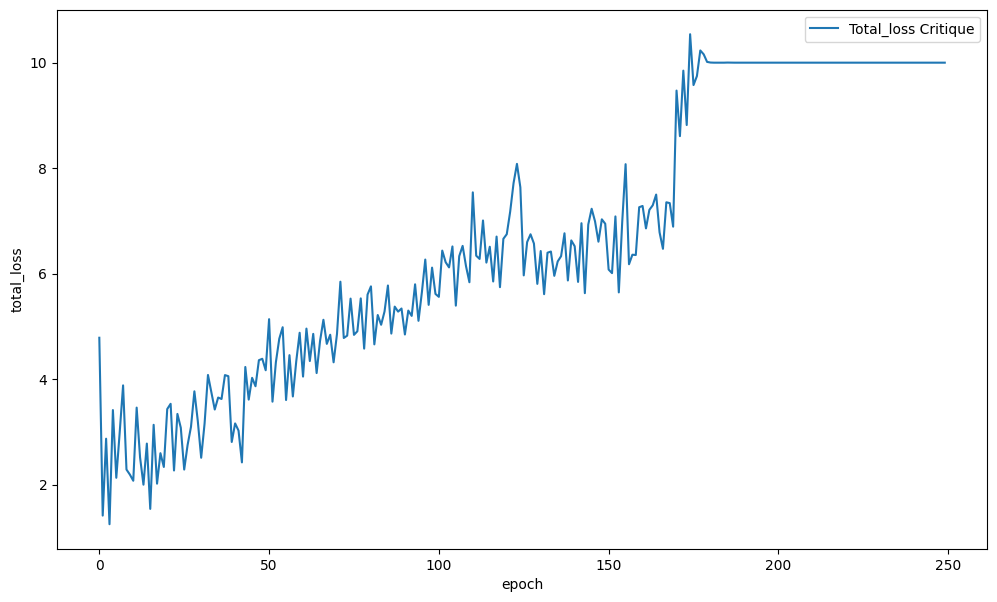

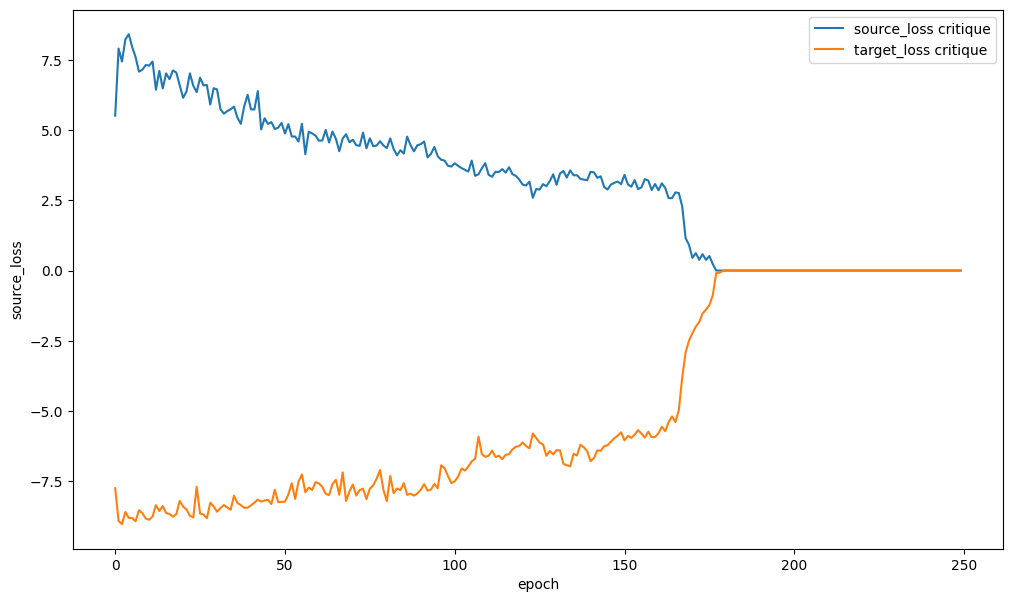

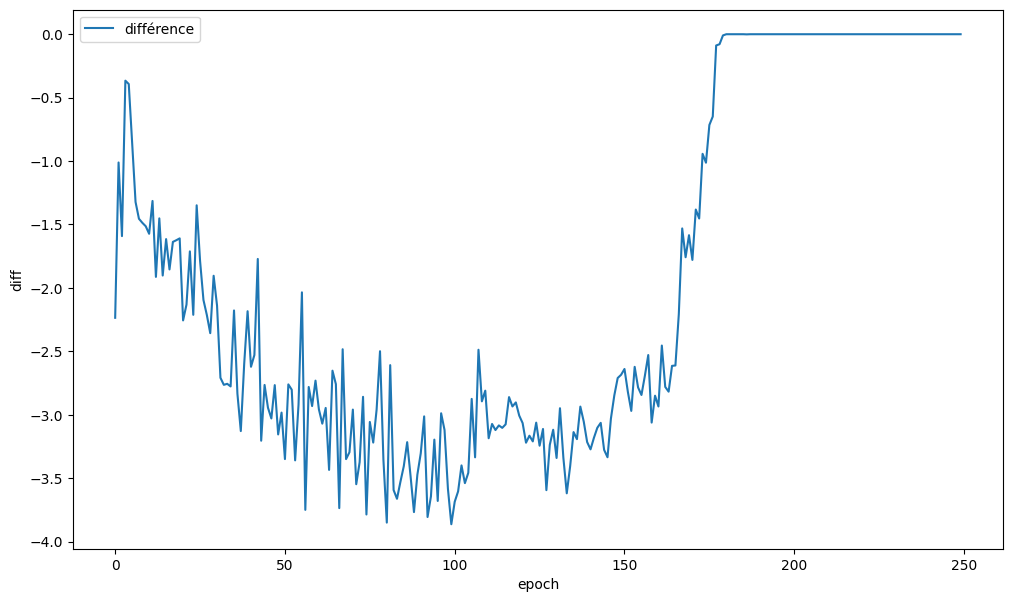

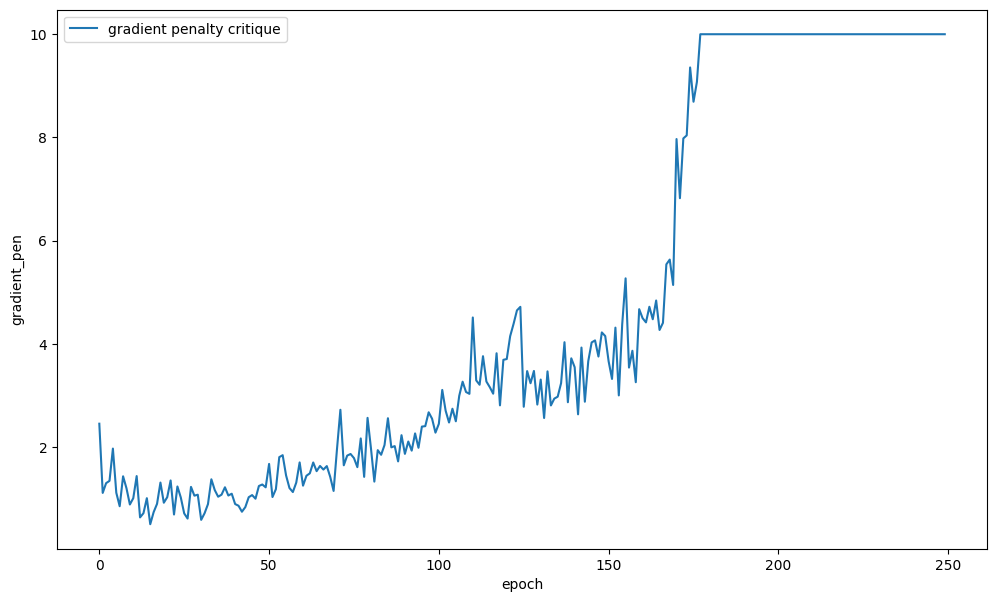

In [7]:
df_le = (
    df_results.sort_values(by=["id", "epoch"], ascending=[False, False])
    .groupby("id", as_index=False)
    .first()
)

plt.figure(figsize=(12, 7))
sns.lineplot(data=df_le, x="epoch", y="total_loss",label="Total_loss Critique")
plt.savefig(path+"Total_loss.png")

#sns.lineplot(data=df_le, x="epoch", y="d_loss_test",label="Discriminator_loss_test")
#sns.lineplot(data=df_le, x="epoch", y="d_loss_val",label="Discriminator_loss_val")

plt.figure(figsize=(12, 7))
sns.lineplot(data=df_le,x="epoch", y="source_loss",label="source_loss critique")
sns.lineplot(data=df_le,x="epoch", y="target_loss",label="target_loss critique")
plt.savefig(path+"Target_loss.png")

plt.figure(figsize=(12, 7))
sns.lineplot(data=df_le,x="epoch", y="diff",label="différence")
plt.savefig(path+"différence_loss.png")

plt.figure(figsize=(12, 7))
sns.lineplot(data=df_le,x="epoch", y="gradient_pen",label="gradient penalty critique")
plt.savefig(path+"grad_penalty.png")

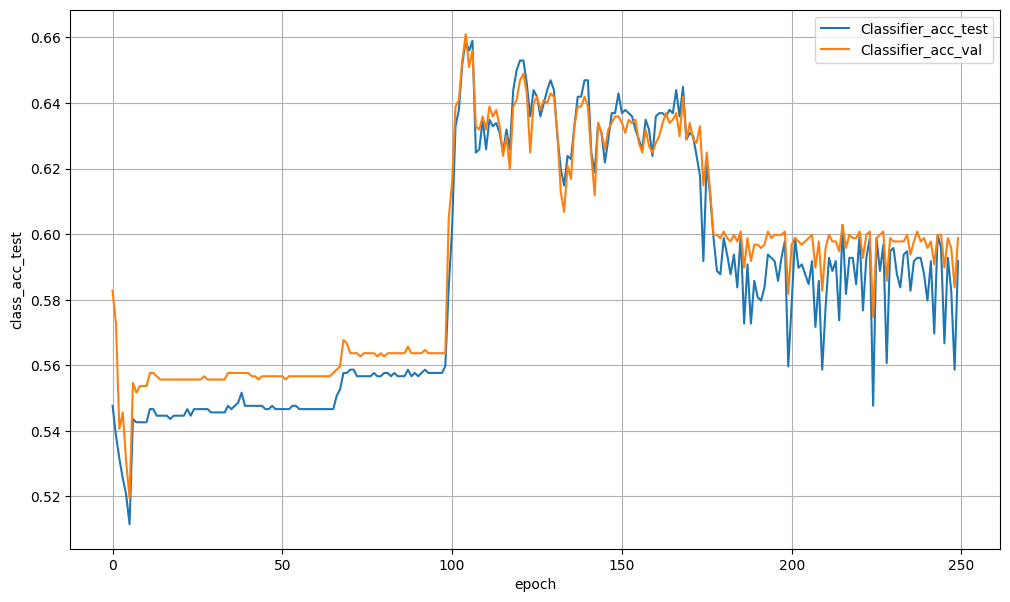

In [8]:
plt.figure(figsize=(12,7))
sns.lineplot(data=df_le, x="epoch", y="class_acc_test", label="Classifier_acc_test")
sns.lineplot(data=df_le, x="epoch", y="class_acc_val", label="Classifier_acc_val")
plt.grid(True)
plt.savefig(path+"classifier_accuracy.png")

## Testing
----------------------------------------------------------